# Results

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [2]:
climate = Climate() 
soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
model.output()

done


,kc,LAI,stress,R,s,E,ET,T,L,dsdt
0,0.300,0.7500,1.000000,0.310389,0.300000,0.099097,0.099097,0.000000,0.0,0.211292
1,0.300,0.7500,1.000000,0.000000,0.300937,0.101427,0.101427,0.000000,0.0,-0.101427
2,0.300,0.7500,1.000000,0.000000,0.300487,0.100306,0.100306,0.000000,0.0,-0.100306
3,0.300,0.7500,1.000000,1.898464,0.300042,0.099202,0.099202,0.000000,0.0,1.799262
4,0.300,0.7500,1.000000,0.000000,0.308021,0.119619,0.119619,0.000000,0.0,-0.119619
5,0.300,0.7500,1.000000,0.000000,0.307491,0.118223,0.118223,0.000000,0.0,-0.118223
6,0.300,0.7500,1.000000,0.000000,0.306967,0.116848,0.116848,0.000000,0.0,-0.116848
7,0.300,0.7500,1.000000,15.323898,0.306448,0.115494,0.115494,0.000000,0.0,15.208403
8,0.300,0.7500,0.736875,5.889036,0.373892,0.330341,0.500243,0.169903,0.0,5.388792
9,0.300,0.7500,0.610472,0.000000,0.397789,0.422616,0.685023,0.262407,0.0,-0.685023


In [3]:
# Average soil moisture during interval of the season
# What this is doing is basically the same as my code before and just returning 
# the average soil moisture values during the "growing" part of the season. 

def avg_sm_gseason(simulations, tstart = 0.5, tend = 0.75):
    result = []

    climate = Climate() 
    soil = Soil('loam')
    crop = Crop(soil=soil)
    soil.set_nZr(crop)  
    model = CropModel(crop=crop,soil=soil,climate=climate)

    model.run()
    fin = model.output()

    for i in range(simulations):
        # This part is not really necessary
        # Tseas is 180 which is just what the model is set to 
        # create variable for DOY
        tseas = 120
        range_tseas = list(range(1,121,1))

        #print(model.s)
        fin['doy'] = range_tseas
        len(fin.doy)

        # Select certain rows
        start = int(tseas*tstart)
        end = int(tseas*tend)
        x = fin.s[start:end]
      
        # Add this value to a list
        result.append(x)
        
    # Make it a float
    return np.array(result, dtype=np.float32)

test = avg_sm_gseason(1000)

test.mean(), test.var()

done


(0.40610132, 0.0013740684)

In [4]:
def dist_avg_sm_gseason_daily(simulations, tstart = 0.5, tend = 0.75):
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)
        model.run()
        fin = model.output()
        
        # Return just the soil moisture in a dataframe
        df['x_' + str(i)] = model.s
        
        # just select the part of the growing season that we want
        tseas = 120

        # Select certain rows
        start = int(tseas*tstart)
        end = int(tseas*tend)
        _df = df[start:end]
        
        # Take average soil moisture across each day
        df2['mean'] = _df.mean(axis=1)
        df2['var'] = _df.var(axis=1)

    return _df, df2 #result

df, df2 = dist_avg_sm_gseason_daily(1000)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


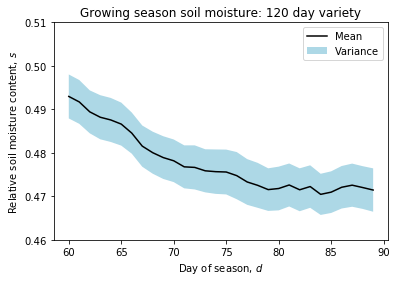

In [5]:
# Plot some stuff
# This is for one climatology and one maize variety (180 days)
plt.plot(df2['mean'], 'k-')
x = np.arange(60, 90, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df2['var']+df2['mean'], df2['mean']-df2['var'],facecolor='lightblue') #, facecolor='lightblue'
plt.title('Growing season soil moisture: 120 day variety')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])
plt.ylim(0.46, 0.51)

# I'm not sure that this is correct but it's somethingt

plt.savefig('../output/figures/AvgGseasSM_120d.pdf', format='pdf')

# Save the data as a csv
df2.to_csv('../output/dataframes/AvgGseasSM_120d.csv', sep=',')
# 

,mean,var
45,0.492313,0.005782
46,0.490536,0.005812
47,0.488125,0.005485
48,0.486777,0.005509
49,0.485134,0.005288
50,0.483570,0.005231
51,0.483400,0.005277
52,0.482234,0.005226
53,0.480275,0.005009
54,0.481516,0.005118


In [59]:
def daily_sm(simulations):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)
        model.run()

        # Return just the soil moisture in a dataframe
        df['x_' + str(i)] = model.s
        
        # Take average soil moisture across each day
        df['mean'] = df.mean(axis=1)
        df['var'] = df.var(axis=1)

    return df #result

fin = daily_sm(10)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


done
done
done
done
done
done
done
done
done
done


In [60]:
fin

,x_0,mean,var,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.300000,0.273180,0.007063,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000
1,0.299561,0.292987,0.009534,0.299561,0.337368,0.307981,0.299561,0.299561,0.331598,0.320941,0.299561,0.431534
2,0.321246,0.297593,0.010029,0.299126,0.336333,0.307451,0.317371,0.299126,0.330742,0.320253,0.299126,0.447985
3,0.320554,0.312937,0.011364,0.298696,0.335330,0.383720,0.316727,0.298696,0.329912,0.319573,0.380964,0.462405
4,0.319870,0.322220,0.012306,0.298271,0.340502,0.381169,0.316092,0.298271,0.385925,0.318902,0.430244,0.456996
5,0.319195,0.324360,0.012140,0.297850,0.339369,0.378705,0.356674,0.297850,0.383298,0.318239,0.426042,0.451794
6,0.318529,0.325594,0.011834,0.320273,0.338272,0.376324,0.355024,0.297434,0.380761,0.326738,0.421994,0.446788
7,0.317871,0.342934,0.013099,0.319593,0.422287,0.374024,0.353428,0.371006,0.378311,0.325975,0.464682,0.441972
8,0.317221,0.370659,0.017374,0.318922,0.418375,0.371801,0.369625,0.521539,0.503916,0.325221,0.481768,0.437336
9,0.316580,0.372693,0.017056,0.336203,0.414606,0.369653,0.367549,0.513785,0.517001,0.343844,0.475608,0.432872


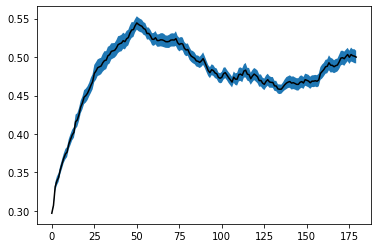

In [23]:
plt.plot(fin['mean'], 'k-')
x = np.arange(0.0, 180, 1)

plt.fill_between(x, fin['var']+fin['mean'], fin['mean']-fin['var'])
                 #v facecolor='red'
# I'm not sure that this is correct but it's somethingt

In [ ]:
def average_soil_moisture(simulations):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)

        model.run()
        model.output()

        # Return average soil moisture
        x = model.s.mean()

        # Add this value to a list
        result.append(x)
        
    return result

# TODO: One enhancement
# Suppress done!

In [ ]:
fin = average_soil_moisture(simulations=1000)

In [ ]:
# This is the average and variance of soil moisture for the 10000s of simulations
import statistics
statistics.mean(fin)